In [2]:
import numpy as np 
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

/Users/claudiacastro/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 1. Segmentación

El objetivo principal de esta tarea es segmentar a los clientes en grupos distintos y homogéneos, con el fin de obtener un conocimiento más profundo de nuestra base de clientes y mejorar la estrategia comercial. 

El análisis de los clusters permitirá identificar patrones y características clave de cada grupo, lo que facilitará la orientación de nuestras acciones comerciales de manera más efectiva. Los resultados de esta segmentación se presentarán con una descripción clara y visual de cada cluster, destacando las diferencias entre ellos.

---

Carga de los dataset ya limpios que se encuentran en s3 de AWS, se unen y se genera un nuevo dataset que se guarda en igual en s3 de AWS para su uso directo.

In [3]:

# productos
prod_df_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/prod_df_cleaned.parquet") 

# sociodemografico
sdg_df_cleaned = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/sociodemographic_df_adrian.parquet')

# comercial activity clean
ca_df_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/commercial_activity_df_clean.parquet") 

# merge de los tres dataframes
df_1_merge = pd.merge(prod_df_cleaned,sdg_df_cleaned, how="inner" ,on=['pk_cid','pk_partition'])

df_2_merge = pd.merge(df_1_merge,ca_df_cleaned, how="inner",on=['pk_cid','pk_partition'])

df_full_cleaned = df_2_merge.copy()

#df_full_cleaned.to_parquet("/Users/claudiacastro/df_full_cleaned.parquet")

Este dataset contiene la limpieza y las nuevas columnas creadas en la etapa anterior.

In [4]:
# Cargando los datos directamente de s3 de AWS
#df_full_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/df_full_cleaned.parquet")
# sociodemografico
#sdg_df_cleaned = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/sociodemographic_df_adrian.parquet')


df_full_clean = df_full_cleaned.copy()
# se mergea la edad que faltaba en el df_full_cleaned 
#df_full_clean = df_full_clean.merge(sdg_df_cleaned[["pk_cid", "pk_partition", "age"]], on=["pk_cid", "pk_partition"], how="inner")

In [5]:
df_full_clean

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,country_id,region_code,gender,age,salary,mes_partition,mes_nombre_partition,grupo_edad,entry_date,entry_channel,active_customer,segment,categoria_antiguedad
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Málaga,H,35,"87,218.100",1,January,Adultos jóvenes,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Ciudad Real,V,23,"35,548.740",1,January,Jóvenes,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Ciudad Real,V,23,"122,179.110",1,January,Jóvenes,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,Zaragoza,H,22,"119,775.540",1,January,Jóvenes,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Zaragoza,V,23,"101,469.135",1,January,Jóvenes,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Zaragoza,V,22,"43,912.170",5,May,Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,"Rioja, La",V,23,"23,334.990",5,May,Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Zaragoza,H,47,"87,930.930",5,May,Adultos,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,Zaragoza,H,22,"199,592.820",5,May,Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años


# 2. Procedimiento para la segmentación de clientes.

La segmentación de clientes implica agrupar a los clientes en segmentos distintos, cada uno caracterizado por ciertas propiedades que describen su comportamiento y relación con la empresa. Aunque existen innumerables características que podrían utilizarse para este propósito, la elección de las características óptimas depende en gran medida del objetivo comercial que se desee alcanzar con dicha segmentación. Por lo tanto, no existe un único enfoque correcto ni una fórmula universal para llevar a cabo una Segmentación de Clientes.

Las variables seleccionadas para el modelo son fundamentales, ya que definirán las diferencias clave entre los grupos. Para realizar una segmentación efectiva que permita un entendimiento más profundo de nuestra base de clientes y la alineación de nuestras estrategias comerciales, es crucial elegir variables que reflejen el comportamiento del cliente en relación con nuestros productos o servicios. 

1. Técnica de Segmentación: Clustering

Existen varias técnicas de segmentación pero para este caso como el dataset contiene una variedad de variables tanto demográficas como de comportamiento, se realiza la técnica de segmentación basada en Clustering, específicamente K-means, que proporciona una visión holística de los diferentes tipos de clientes.

---
2. Selección de Variables:

Una vez definido la técnica de segmentación, a continuación se definen 3 análisis basados en el clustering que se va a implementar según las diferentes variables presentes: 

Para construir clusters significativos, es crucial elegir variables que reflejen tanto el comportamiento financiero de los clientes como sus características demográficas. Una selección de variables podría ser el siguiente:

Variables Demográficas:

1.	age (Edad): Es fundamental para entender la etapa de vida en la que se encuentra el cliente, lo que afecta sus necesidades financieras.

2.	country_id (País de residencia): Podría ser útil para identificar variaciones geográficas en el comportamiento de los clientes.
3.	region_code (Provincia): Para segmentar a nivel más granular dentro de un país, especialmente si hay diferencias regionales significativas.
4.  gender (Sexo): Aunque menos relevante en algunos casos, podría influir en la preferencia por ciertos productos financieros.
5.	salary (Ingresos brutos): Indica la capacidad de compra e inversión del cliente, crucial para segmentar en términos de valor potencial.

Variables de Comportamiento Financiero:

1.	active_customer (Actividad del cliente): Indicador de si el cliente está activamente utilizando los productos, importante para identificar clientes leales o en riesgo de abandono.

2.	entry_channel (Canal de captación): Puede influir en el comportamiento inicial y la adopción de productos del cliente.

3.	credit_card, debit_card (Tarjetas de crédito/débito): Reflejan el uso de productos financieros cotidianos y la disposición del cliente a utilizar crédito.
	
4.	em_account_p, em_account_pp, em_acount, emc_account (Cuentas de easyMoney): Estas variables muestran el nivel de compromiso del cliente con los diferentes productos de la empresa, siendo clave para entender la amplitud de su relación con la empresa.
	
5.	loans, mortgage (Préstamos e Hipotecas): Indican el nivel de deuda y el compromiso financiero a largo plazo del cliente.

6.	funds, securities (Fondos y Valores): Reflejan la predisposición del cliente a invertir y su perfil de riesgo.

7.	short_term_deposit, long_term_deposit (Depósitos a corto y largo plazo): Muestran las preferencias del cliente por la seguridad y el rendimiento financiero a corto o largo plazo.

8.	payroll, payroll_account (Domiciliaciones y cuentas bonificadas): Indican el nivel de vinculación del cliente con la empresa a través de la domiciliación de su salario y otros ingresos recurrentes.

9.	pension_plan (Plan de pensiones): Refleja la planificación a largo plazo del cliente y su preocupación por la jubilación.

10. categoria_antiguedad: Muestra la retención del cliente a largo plazo.


---
3. Implementación del Clustering:

Preprocesamiento:

- Análisis de variables para identificar relevancia agrupando por clientes y creación del dataset por la segmentación.
  
- Se analiza la correlación entre las variables para identificar y eliminar aquellas que estén altamente correlacionadas y así evitar la redundancia y mejorar la eficiencia del modelo de clustering.

- Se estandarizan las variables numéricas para que tengan igual peso en el análisis.

Ejecución del Clustering:

- Se realiza un análisis de clustering utilizando K-means teniendo en cuenta 3 enfoques: Clustering con el dataset completo, con reduccion de la dimensionalidad y con Ingenería de Caracteristicas
  
- Se determina el enfoque adecuado y se identifica el número óptimo de clusters usando técnicas como el método del codo o el análisis de la silueta.

Interpretación de los Clusters:

•	Se analiza cada cluster para entender las características principales.






---

## 2.1. Implementación del Clustering (K-means)

### 1. Preprocesamiento

En esta sección, se llevará a cabo un análisis de las variables presentes en el dataset con el objetivo de identificar aquellas que son más relevantes para el estudio, lo cual es crucial para simplificar el modelo, mejorar el rendimiento y facilitar la interpretación de los resultados.

1. Se agrupan los clientes segun los productos a lo largo de las particiones, se calcula la media por cada producto para indicar el grado de usabilidad.

In [6]:
productos = df_full_clean.columns[2:17]
productos
df_productos_usos = df_full_clean.groupby("pk_cid")[productos].mean()
df_productos_usos.head()

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
pk_cid,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.000,0.889
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.000,0.000,0.000,0.294,0.000,1.000


2. Se agrupa por cliente para obtener el maximo de productos contratados por cada cliente hasta la fecha

In [7]:
df_cant_prod_contratados = df_full_clean.groupby("pk_cid")["num_products_contracts"].max()
df_cant_prod_contratados

pk_cid
15891      1
16063      0
16203      1
16502      2
17457      3
          ..
1553685    0
1553686    0
1553687    0
1553688    0
1553689    0
Name: num_products_contracts, Length: 456373, dtype: int64

3. Region_Code.

Para tratar la columna region_code se puede utilizar One-Hot Encoding y/o Label Encoding pero en este contexto y para evitar la alta dimensionalidad y relaciones ordinales incorrectas, y así asegurar un mejor rendimiento y precisión del modelo KMeans, se decide utilizar el Frequency Encoding ya que se busca una representación más detallada que capture la variabilidad en la distribución de clientes por provincia. 

Nota: otro enfoque pudiera ser distinguir entre áreas con alta y baja densidad de clientes, y con una codificación binaria para las provincias más pobladas hubiese sido suficiente.



Pasos para Aplicar Frequency Encoding

- Calcular la Frecuencia de Cada Provincia: Primero, cuentas cuántas veces aparece cada provincia en el dataset.

- Reemplazar la Provincia por su Frecuencia: Luego, asignas la frecuencia calculada a cada cliente en función de su provincia de residencia.

In [8]:
# Paso 1: Calcular la frecuencia de cada provincia
frecuencias_provincia = df_full_clean['region_code'].value_counts(normalize=True)  # normalize=True para obtener las frecuencias relativas

# Paso 2: Mapear las frecuencias a la columna de provincia
df_full_clean['region_code_encoded'] = df_full_clean['region_code'].map(frecuencias_provincia)

df_region_code_frecuency = df_full_clean.groupby("pk_cid")["region_code_encoded"].last()

# Verificar los resultados
print(df_full_clean[['region_code', 'region_code_encoded']].head())

   region_code  region_code_encoded
0       Málaga                0.032
1  Ciudad Real                0.012
2  Ciudad Real                0.012
3     Zaragoza                0.022
4     Zaragoza                0.022


4. Transformación de las fechas de entry_date a formato numérico

In [9]:
# eliminar la columna entry_date que tampoco aporta información
df_entry_date = df_full_clean.groupby("pk_cid")["entry_date"].first()

# llevar df_entry_date a formato numerico

df_entry_date = pd.to_datetime(df_entry_date)
df_entry_date = df_entry_date.apply(lambda x: x.toordinal())
df_entry_date

pk_cid
15891      736903
16063      737017
16203      737051
16502      736967
17457      736588
            ...  
1553685    737210
1553686    737210
1553687    737210
1553688    737210
1553689    737210
Name: entry_date, Length: 456373, dtype: int64

5. Se eliminan las variables country_id, deceased, em_account_pp por no brindar suficiente información.

Nota: La variable deceased fue eliminada desde la Tarea 1.

In [10]:
df_full_clean['country_id'] = np.where( df_full_clean['country_id'] == 'ES', 1, 0)
df_full_clean.groupby('pk_cid')['country_id'].last().value_counts()

country_id
1    456209
0       164
Name: count, dtype: int64

In [11]:
df_full_clean["em_account_pp"].value_counts()

em_account_pp
0    5962924
Name: count, dtype: int64

In [12]:
df_full_clean.drop(columns=["country_id","em_account_pp"],inplace=True)

6. También se elimina la variable mes_nombre_partition ya que viene siendo lo mismo que mes_partition

In [13]:
df_full_clean.drop(columns=["mes_nombre_partition"],inplace=True)

7. Active_customer. Para esta variable se agrupa por clientes y se obtiene su media que indica el grado medio de actividad de los clientes en la aplicacion.

In [14]:
df_active_customer = df_full_clean.groupby("pk_cid")["active_customer"].mean()  

8. Para el resto de las variables no se precisa ninguna transformación ya que vienen limpias de la Tarea 1, así que nos quedaremos con el ultimo valor que practicamente viene siendo el mismo en todas las particiones para cada uno de los clientes

In [15]:
clean_variable = [	"gender","salary", "grupo_edad","mes_partition","grupo_edad","age",	"entry_channel",
                "segment",	"categoria_antiguedad"]
df_clean_variables = df_full_clean.groupby('pk_cid')[clean_variable].last()
df_clean_variables

,gender,salary,grupo_edad,mes_partition,grupo_edad,age,entry_channel,segment,categoria_antiguedad
pk_cid,,,,,,,,,
15891,H,"132,384.450",Adultos mayores,8,Adultos mayores,59,KAT,02 - PARTICULARES,0-3 meses
16063,H,"132,384.450",Adultos mayores,5,Adultos mayores,62,KAT,02 - PARTICULARES,6-9 meses
16203,V,"153,902.880",Ancianos,5,Ancianos,70,KAT,01 - TOP,3-6 meses
16502,H,"132,384.450",Adultos mayores,5,Adultos mayores,58,KHN,02 - PARTICULARES,6-9 meses
17457,H,"102,405.750",Adultos,5,Adultos,54,KAT,02 - PARTICULARES,1-2 años
...,...,...,...,...,...,...,...,...,...
1553685,V,"114,633.765",Adultos,5,Adultos,52,Otros,03 - UNIVERSITARIO,0-3 meses
1553686,H,"85,787.220",Adultos jóvenes,5,Adultos jóvenes,30,Otros,03 - UNIVERSITARIO,0-3 meses
1553687,V,"143,419.770",Jóvenes,5,Jóvenes,21,Otros,03 - UNIVERSITARIO,0-3 meses


Dataset para la Segmentación

- Ahora pasamos a unir los dataset que se han ido creando a lo largo de este analisis para finalmente obtener el dataset para la segmentación.

In [16]:
# inicializamos el dataframe de clustering con el dataframe de productos_usos
df_clustering = df_productos_usos.copy()

# Uniendo el dataframe de df_clustering con el dataframe de cant_prod_contratados
df_clustering = df_clustering.join(df_cant_prod_contratados)

# Uniendo el dataframe de df_clustering con el dataframe de entry_date
df_clustering = df_clustering.join(df_entry_date)

# Uniendo el dataframe de df_clustering con el dataframe de active_customer
df_clustering = df_clustering.join(df_active_customer)

# Uniendo el dataframe de df_clustering con el dataframe de df_region_code_frecuency
df_clustering = df_clustering.join(df_region_code_frecuency)

# Uniendo el dataframe de df_clustering con el dataframe de df_clean_variables
df_clustering = df_clustering.join(df_clean_variables)

df_clustering


,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,entry_date,active_customer,region_code_encoded,gender,salary,grupo_edad,mes_partition,grupo_edad,age,entry_channel,segment,categoria_antiguedad
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,1,736903,0.500,0.199,H,"132,384.450",Adultos mayores,8,Adultos mayores,59,KAT,02 - PARTICULARES,0-3 meses
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737017,0.714,0.199,H,"132,384.450",Adultos mayores,5,Adultos mayores,62,KAT,02 - PARTICULARES,6-9 meses
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,1,737051,0.833,0.101,V,"153,902.880",Ancianos,5,Ancianos,70,KAT,01 - TOP,3-6 meses
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.000,0.889,2,736967,0.889,0.199,H,"132,384.450",Adultos mayores,5,Adultos mayores,58,KHN,02 - PARTICULARES,6-9 meses
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.000,0.000,0.000,0.294,0.000,1.000,3,736588,1.000,0.199,H,"102,405.750",Adultos,5,Adultos,54,KAT,02 - PARTICULARES,1-2 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737210,0.000,0.012,V,"114,633.765",Adultos,5,Adultos,52,Otros,03 - UNIVERSITARIO,0-3 meses
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737210,0.000,0.049,H,"85,787.220",Adultos jóvenes,5,Adultos jóvenes,30,Otros,03 - UNIVERSITARIO,0-3 meses
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737210,0.000,0.199,V,"143,419.770",Jóvenes,5,Jóvenes,21,Otros,03 - UNIVERSITARIO,0-3 meses


### 2. Analisis de correlación

1. Para llevar a cabo el análisis de correlacion lo primero que se hace es llevar todas las columnas categóricas a numéricas.

In [17]:
# verificando los tipos de datos y corrigiendo los que sean necesarios
df_clustering["region_code_encoded"] = df_clustering["region_code_encoded"].astype("float")
df_clustering["grupo_edad"] = df_clustering["grupo_edad"].astype("category")
df_clustering["entry_channel"] = df_clustering["entry_channel"].astype("category")
df_clustering["gender"] = df_clustering["gender"].astype("category")
df_clustering.dtypes

short_term_deposit         float64
loans                      float64
mortgage                   float64
funds                      float64
securities                 float64
long_term_deposit          float64
em_account_pp              float64
credit_card                float64
payroll                    float64
pension_plan               float64
payroll_account            float64
emc_account                float64
debit_card                 float64
em_account_p               float64
em_acount                  float64
num_products_contracts       int64
entry_date                   int64
active_customer            float64
region_code_encoded        float64
gender                    category
salary                     float64
grupo_edad                category
mes_partition                int32
grupo_edad                category
age                          int64
entry_channel             category
segment                   category
categoria_antiguedad      category
dtype: object

In [18]:
# Identificar las columnas categóricas
columnas_categoricas = df_clustering.dtypes.loc[df_clustering.dtypes == "category"].index.tolist()

# Aplicar one-hot encoding usando pandas.get_dummies
df_numerico_segmetacion_1 = pd.get_dummies(df_clustering, columns=columnas_categoricas, drop_first=True, dtype=int)

# Verificar el resultado
df_numerico_segmetacion_1

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,entry_date,active_customer,region_code_encoded,salary,mes_partition,age,gender_V,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Otros,entry_channel_RED,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,categoria_antiguedad_3-6 meses,categoria_antiguedad_6-9 meses,categoria_antiguedad_9-12 meses,categoria_antiguedad_1-2 años,categoria_antiguedad_2-3 años,categoria_antiguedad_Más de 3 años
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,1,736903,0.500,0.199,"132,384.450",8,59,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737017,0.714,0.199,"132,384.450",5,62,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,1,737051,0.833,0.101,"153,902.880",5,70,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.000,0.889,2,736967,0.889,0.199,"132,384.450",5,58,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.000,0.000,0.000,0.294,0.000,1.000,3,736588,1.000,0.199,"102,405.750",5,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737210,0.000,0.012,"114,633.765",5,52,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737210,0.000,0.049,"85,787.220",5,30,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,737210,0.000,0.199,"143,419.770",5,21,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


2. Una vez convertido las variables categóricas a numéricas, pasamos hacer el análisis de correlación

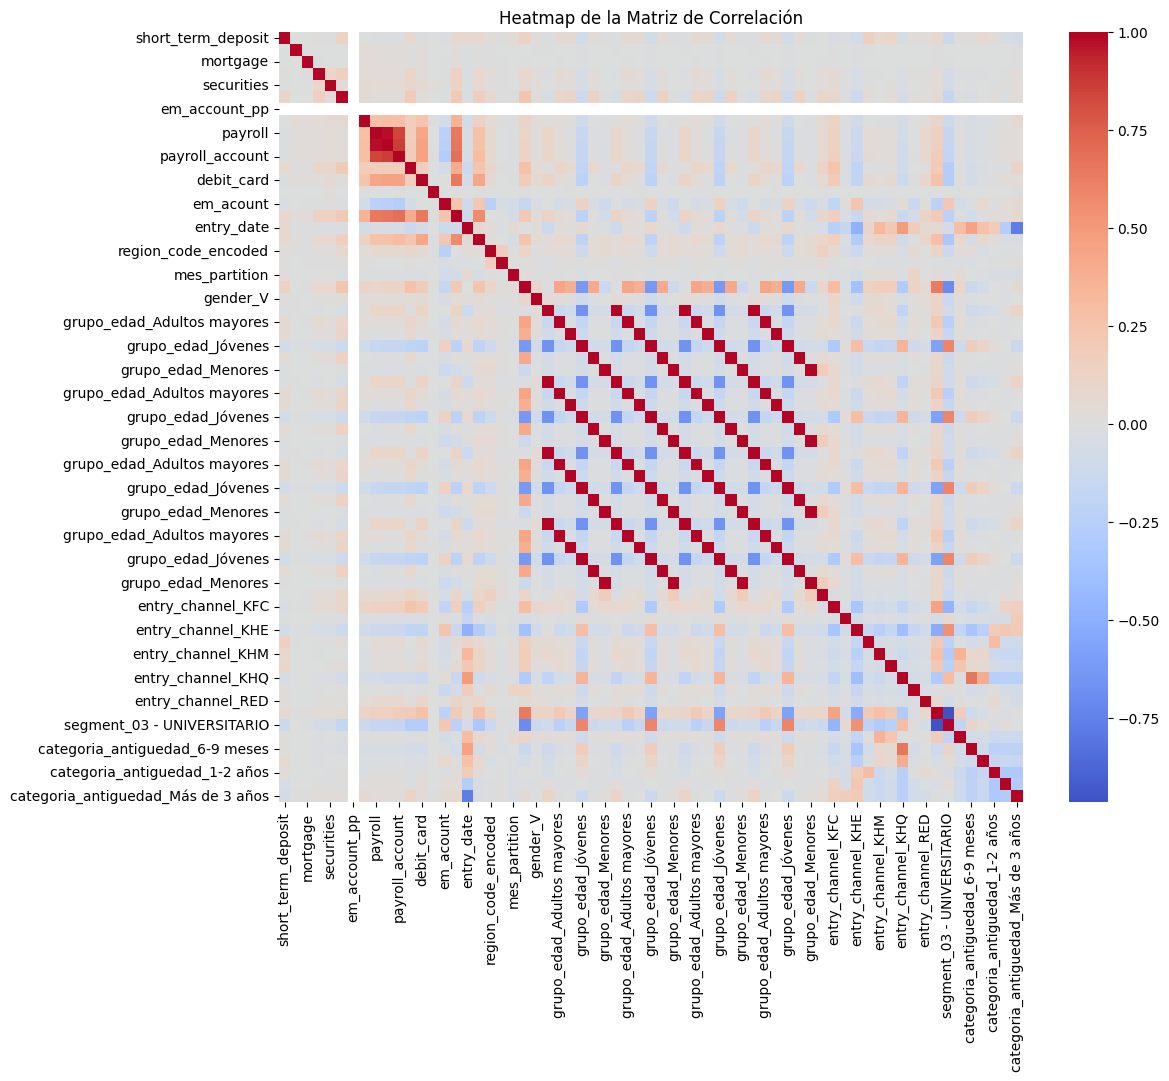

Pares de variables altamente correlacionadas:
('payroll', 'pension_plan')
('grupo_edad_Adultos jóvenes', 'grupo_edad_Adultos jóvenes')
('grupo_edad_Adultos jóvenes', 'grupo_edad_Adultos jóvenes')
('grupo_edad_Adultos jóvenes', 'grupo_edad_Adultos jóvenes')
('grupo_edad_Adultos mayores', 'grupo_edad_Adultos mayores')
('grupo_edad_Adultos mayores', 'grupo_edad_Adultos mayores')
('grupo_edad_Adultos mayores', 'grupo_edad_Adultos mayores')
('grupo_edad_Ancianos', 'grupo_edad_Ancianos')
('grupo_edad_Ancianos', 'grupo_edad_Ancianos')
('grupo_edad_Ancianos', 'grupo_edad_Ancianos')
('grupo_edad_Jóvenes', 'grupo_edad_Jóvenes')
('grupo_edad_Jóvenes', 'grupo_edad_Jóvenes')
('grupo_edad_Jóvenes', 'grupo_edad_Jóvenes')
('grupo_edad_Longevos', 'grupo_edad_Longevos')
('grupo_edad_Longevos', 'grupo_edad_Longevos')
('grupo_edad_Longevos', 'grupo_edad_Longevos')
('grupo_edad_Menores', 'grupo_edad_Menores')
('grupo_edad_Menores', 'grupo_edad_Menores')
('grupo_edad_Menores', 'grupo_edad_Menores')
('grupo_

In [19]:
# Calcular la matriz de correlación
matriz_correlacion = df_numerico_segmetacion_1.corr()

# Visualizar la matriz de correlación utilizando un heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacion, cmap='coolwarm', center=0)
plt.title('Heatmap de la Matriz de Correlación')
plt.show()

# Identificar variables altamente correlacionadas
umbral = 0.9
correlaciones_altas = np.where(np.abs(matriz_correlacion) > umbral)
pares_correlacionados = [(matriz_correlacion.index[x], matriz_correlacion.columns[y]) for x, y in zip(*correlaciones_altas) if x != y and x < y]

print("Pares de variables altamente correlacionadas:")
for par in pares_correlacionados:
    print(par)

Analizando las variables para determinar cuál es mejor eliminar, en los dos casos, ambas variables representan a aspectos específicos de clientes. Por lo tanto aunque estén correlacionadas, se van a mantener ya que pueden ofrecer diferentes insights. Por tanto, mantenemos todas las variables.


### 3. Estandarización de las variables numéricas

In [20]:
# Initialize the scaler
scaler = RobustScaler()

# Fit and transform the data
df_estandarizado = scaler.fit_transform(df_numerico_segmetacion_1)

# Convert the result to a DataFrame
df_estandarizado = pd.DataFrame(df_estandarizado , columns=df_numerico_segmetacion_1.columns)

# Verify the results
df_estandarizado

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,entry_date,active_customer,region_code_encoded,salary,mes_partition,age,gender_V,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Otros,entry_channel_RED,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,categoria_antiguedad_3-6 meses,categoria_antiguedad_6-9 meses,categoria_antiguedad_9-12 meses,categoria_antiguedad_1-2 años,categoria_antiguedad_2-3 años,categoria_antiguedad_Más de 3 años
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.500,0.000,0.486,0.500,1.869,0.749,3.000,2.429,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,0.641,0.714,1.869,0.749,0.000,2.643,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-1.000,0.000,1.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.167,0.000,0.688,0.833,0.694,1.115,0.000,3.214,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,1.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.000,-0.111,1.000,0.573,0.889,1.869,0.749,0.000,2.357,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,-1.000,0.000,1.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.000,0.000,0.000,0.294,0.000,0.000,2.000,0.058,1.000,1.869,0.238,0.000,2.071,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-1.000,0.000,0.000,0.000,1.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456368,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,0.904,0.000,-0.371,0.447,0.000,1.929,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
456369,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,0.904,0.000,0.071,-0.044,0

## 2.2. Ejecución del Clustering

Para optimizar la segmentación y obtener la mejor agrupación posible de los datos, se han definido tres enfoques distintos de clustering:

1.	Clustering con el Dataset Completo: En este enfoque, se aplicará el algoritmo de clustering directamente sobre el dataset completo, utilizando todas las variables originales a partir de la estandarización. (df_estandarizado)


2.	Clustering con Reducción de Dimensionalidad mediante PCA: En el segundo enfoque, se aplicará la técnica de Análisis de Componentes Principales (PCA) para reducir la dimensionalidad del dataset. Esta reducción ayudará a identificar los componentes principales que capturan la mayor parte de la varianza de los datos originales. Posteriormente, se aplicará el algoritmo de clustering sobre el dataset reducido para evaluar si la reducción de dimensionalidad mejora la segmentación.


3.	Clustering con Ingeniería de Características: El tercer enfoque se centrará en la creación de nuevas características relevantes a partir de las variables existentes. Luego, se aplicará el algoritmo de clustering.

Cada uno de estos enfoques será evaluado en términos de calidad de la segmentación, utilizando métricas como la inercia y la puntuación de silueta, entre otras. El objetivo es identificar el enfoque que proporciona los clusters más claros, significativos y útiles para las aplicaciones comerciales del análisis.


### 1. Clustering con el Dataset Completo

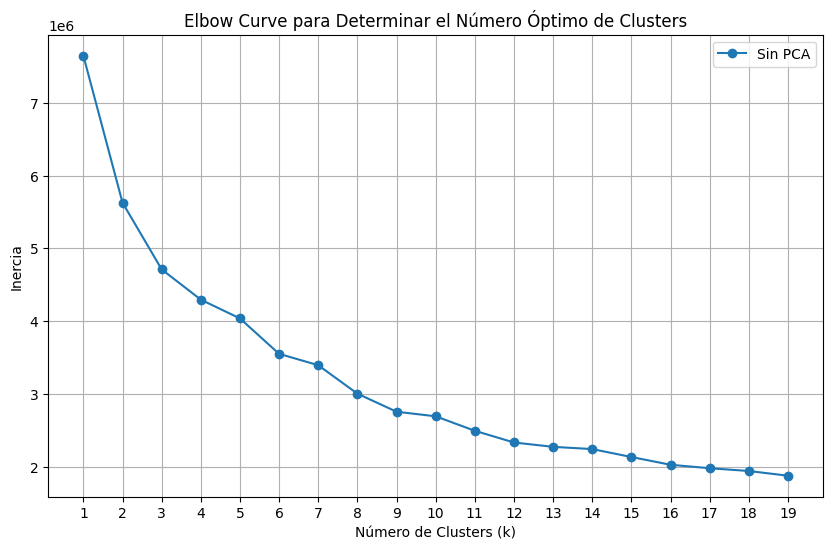

In [21]:
# Definir un rango de k (número de clusters) para probar
rango_k = range(1, 20)
inercias = []

for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_estandarizado)
    inercias.append(kmeans.inertia_)

# Graficar ambas curvas de codo en el mismo gráfico
plt.figure(figsize=(10, 6))
plt.plot(rango_k, inercias, marker='o', linestyle='-', label='Sin PCA')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Elbow Curve para Determinar el Número Óptimo de Clusters')
plt.xticks(rango_k)
plt.grid(True)
plt.legend()
plt.show()


•	La curva de codo muestra una fuerte disminución de la inercia a medida que el número de clusters aumenta de 1 a aproximadamente 4 o 5. Después de ese punto, la reducción de la inercia se vuelve menos pronunciada y tiende a estabilizarse a medida que el número de clusters aumenta.

•	Basado en la observación del gráfico, 4 parece ser el número óptimo de clusters. Esto significa que segmentar los datos en 4 grupos podría capturar la estructura inherente de los datos de manera eficiente, con una buena representación de la variabilidad y sin complejidad innecesaria.

### 2. Clustering con Reducción de Dimensionalidad mediante PCA

Se ejecuta este analisis a partir del df_estandarizado

Este analisis se centra en identificar la cantidad de componentes principales para retener el 95% de la varianza en el dataset df_estandarizado.

Y una vez reducido el dataset de 41 variables a 8 se le aplica el clustering.

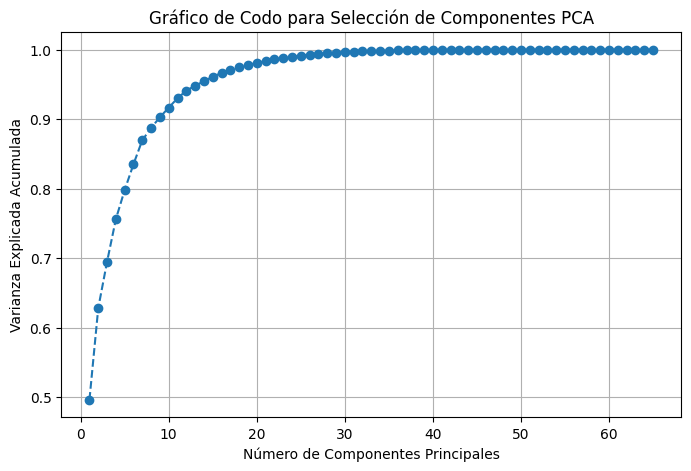

Número de componentes: 14
     PC1   PC2    PC3    PC4    PC5    PC6    PC7   PC8   PC9   PC10   PC11  \
0  0.490 1.741  0.077 -2.784 -0.578  1.204 -2.367 0.429 0.990 -0.015 -0.317   
1  0.494 1.451 -0.347 -3.138 -0.518 -0.433  0.280 0.162 1.039 -0.011 -0.247   
2  0.792 1.745  0.540 -2.238  0.567 -0.142  0.279 0.445 0.619 -0.226 -1.304   
3  0.480 2.068  1.216 -1.997 -0.845 -0.150  0.187 0.229 1.207 -0.095 -0.477   
4 -0.032 2.237  1.848 -1.002 -1.094 -0.327 -0.146 0.877 0.544 -0.300  0.168   

    PC12   PC13   PC14  
0 -0.110  0.006  0.973  
1  0.167  0.087  1.157  
2  0.048  0.376 -0.569  
3 -0.173 -0.018  0.792  
4 -0.385 -0.285 -0.360  


In [22]:
# Aplicar PCA
pca = PCA()
pca.fit(df_estandarizado)

# Varianza explicada por cada componente
varianza_explicada = pca.explained_variance_ratio_
varianza_explicada_acumulada = np.cumsum(varianza_explicada)

# Plot de varianza explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(varianza_explicada_acumulada) + 1), varianza_explicada_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Gráfico de Codo para Selección de Componentes PCA')
plt.grid(True)
plt.show()

# Selección de número de componentes que expliquen al menos el 95% de la varianza
n_componentes = np.argmax(varianza_explicada_acumulada >= 0.95) + 1
print(f"Número de componentes: {n_componentes}")

# Aplicar PCA con el número óptimo de componentes
pca = PCA(n_components=n_componentes)
caracteristicas_reducidas = pca.fit_transform(df_estandarizado)

# Crear un DataFrame con los componentes principales
df_pca = pd.DataFrame(caracteristicas_reducidas, columns=[f'PC{i+1}' for i in range(n_componentes)])

# Mostrar los primeros registros con los componentes principales
print(df_pca.head())

El gráfico de codo para la selección de componentes principales muestra la varianza explicada acumulada por el número de componentes principales.

•	Número de Componentes Seleccionados: Se han identificado 13 componentes principales, lo cual es razonable ya que se busca retener la mayoría de la varianza (normalmente se busca retener al menos el 90-95% de la varianza). Esto significa que, aunque tu dataset original tenía 47 variables, puedes reducirlo a 13 componentes principales sin perder mucha información. Estos componentes representan combinaciones lineales de las variables originales que capturan la estructura de los datos.

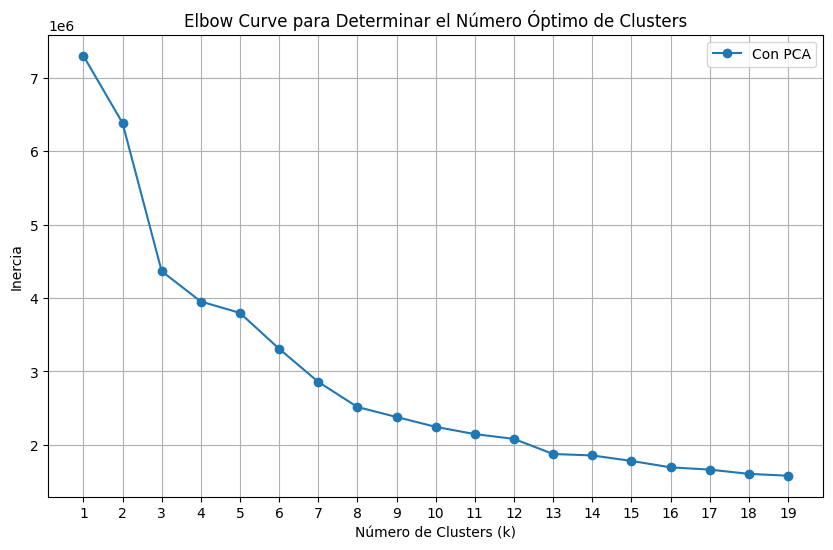

In [23]:
# Definir un rango de k (número de clusters) para probar
rango_k = range(1, 20)
inercias = []

for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    inercias.append(kmeans.inertia_)

# Graficar ambas curvas de codo en el mismo gráfico
plt.figure(figsize=(10, 6))
plt.plot(rango_k, inercias, marker='o', linestyle='-', label='Con PCA')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Elbow Curve para Determinar el Número Óptimo de Clusters')
plt.xticks(rango_k)
plt.grid(True)
plt.legend()
plt.show()

Aparentemente parece que presenta el mismo comportamiento que en el analisis anterior, pero se ha reducido los valores de la inercia lo cual es importante ya que implica que los cluster sean más compactos, además al parecer el cluster optimo se encuentra entre  k = 4, 5 o 6. Un analisis más profundo se realiza al final.

### 3. Clustering con Ingeniería de Características

En esta etapa se trabaja con el df_clustering con todas las variables originales, al que se le va a aplicar ingenieria de caracteristicas, para luego analizar su correlacion, estandarizar y aplicar el clustering

1. Se crean nuevas columnas agrupando los productos en tres categorias: cuentas, ahorro_inversion y financiacion.

In [24]:
# Crear nuevas columnas para las categorías
df_clustering['cuentas'] = df_clustering[['short_term_deposit', 'long_term_deposit', 'payroll_account', 
                             'em_account_pp', 'em_account_p', 'em_acount', 'emc_account']].mean(axis=1)

df_clustering['ahorro_inversion'] = df_clustering[['funds', 'securities', 'pension_plan']].mean(axis=1)

df_clustering['financiacion'] = df_clustering[['loans', 'credit_card', 'mortgage', 'debit_card']].mean(axis=1)


# Eliminar las columnas de productos
df_clustering.drop(columns=productos, inplace=True)

In [25]:
df_clustering

,num_products_contracts,entry_date,active_customer,region_code_encoded,gender,salary,grupo_edad,mes_partition,grupo_edad,age,entry_channel,segment,categoria_antiguedad,cuentas,ahorro_inversion,financiacion
pk_cid,,,,,,,,,,,,,,,,
15891,1,736903,0.500,0.199,H,"132,384.450",Adultos mayores,8,Adultos mayores,59,KAT,02 - PARTICULARES,0-3 meses,0.071,0.000,0.000
16063,0,737017,0.714,0.199,H,"132,384.450",Adultos mayores,5,Adultos mayores,62,KAT,02 - PARTICULARES,6-9 meses,0.000,0.000,0.000
16203,1,737051,0.833,0.101,V,"153,902.880",Ancianos,5,Ancianos,70,KAT,01 - TOP,3-6 meses,0.119,0.000,0.000
16502,2,736967,0.889,0.199,H,"132,384.450",Adultos mayores,5,Adultos mayores,58,KHN,02 - PARTICULARES,6-9 meses,0.206,0.000,0.000
17457,3,736588,1.000,0.199,H,"102,405.750",Adultos,5,Adultos,54,KAT,02 - PARTICULARES,1-2 años,0.277,0.000,0.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0,737210,0.000,0.012,V,"114,633.765",Adultos,5,Adultos,52,Otros,03 - UNIVERSITARIO,0-3 meses,0.000,0.000,0.000
1553686,0,737210,0.000,0.049,H,"85,787.220",Adultos jóvenes,5,Adultos jóvenes,30,Otros,03 - UNIVERSITARIO,0-3 meses,0.000,0.000,0.000
1553687,0,737210,0.000,0.199,V,"143,419.770",Jóvenes,5,Jóvenes,21,Otros,03 - UNIVERSITARIO,0-3 meses,0.000,0.000,0.000


2. Se categorizan los canales de entrada entre principales y secundarios.

In [26]:

# Lista de canales considerados como principales
canales_principales = ['KHE', 'KHQ', 'KFC']

# Crear una nueva columna para categorizar los canales
df_clustering['entry_channel_group'] = df_clustering['entry_channel'].apply(lambda x: 'Canal Principal' if x in canales_principales else 'Canal Secundario')

# Eliminar la columna original
df_clustering.drop(columns=['entry_channel'], inplace=True)


3. Se toma la decision de eliminar las siguientes variables para evitar riesgos de redundancia:


In [27]:
df_clustering.drop(columns=['segment'], inplace=True)
df_clustering.drop(columns=['grupo_edad'], inplace=True)
df_clustering.drop(columns=['gender'], inplace=True)
df_clustering.drop(columns=['region_code_encoded'], inplace=True)  

4. Se codifica la variable categoria_antiguedad segun la frecuencia que se repite cada categoria

In [28]:
# Paso 1: Calcular la frecuencia de cada categoria_antiguedad
frecuencias_antigueda = df_clustering['categoria_antiguedad'].value_counts(normalize=True)  # normalize=True para obtener las frecuencias relativas

# Paso 2: Mapear las frecuencias a la columna de categoria_antiguedad
df_full_clean['categoria_antiguedad_encoded'] = df_clustering['categoria_antiguedad'].map(frecuencias_antigueda)

# se agrupa por pk_cid y se toma el último valor de la columna categoria_antiguedad_encoded
df_antiguedad_frecuency = df_full_clean.groupby("pk_cid")["categoria_antiguedad_encoded"].last()

# eliminar la columna categoria_antiguedad
df_clustering.drop(columns=['categoria_antiguedad'], inplace=True)

In [29]:
df_clustering

,num_products_contracts,entry_date,active_customer,salary,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group
pk_cid,,,,,,,,,,
15891,1,736903,0.500,"132,384.450",8,59,0.071,0.000,0.000,Canal Secundario
16063,0,737017,0.714,"132,384.450",5,62,0.000,0.000,0.000,Canal Secundario
16203,1,737051,0.833,"153,902.880",5,70,0.119,0.000,0.000,Canal Secundario
16502,2,736967,0.889,"132,384.450",5,58,0.206,0.000,0.000,Canal Secundario
17457,3,736588,1.000,"102,405.750",5,54,0.277,0.000,0.074,Canal Secundario
...,...,...,...,...,...,...,...,...,...,...
1553685,0,737210,0.000,"114,633.765",5,52,0.000,0.000,0.000,Canal Secundario
1553686,0,737210,0.000,"85,787.220",5,30,0.000,0.000,0.000,Canal Secundario
1553687,0,737210,0.000,"143,419.770",5,21,0.000,0.000,0.000,Canal Secundario


5. Se clasifican los salarios en bajos, medios y altos.

In [30]:
# Supongamos que tienes un DataFrame 'df' con una columna 'salary' que representa los salarios
# Asegúrate de que los valores de 'salary' estén en formato numérico
df_clustering['salary'] = df_clustering['salary'].replace(',', '', regex=True).astype(float)

# Calcular los percentiles para definir los umbrales
low_threshold = df_clustering['salary'].quantile(0.33)
high_threshold = df_clustering['salary'].quantile(0.66)

# Definir una función para clasificar los salarios
def categorize_salary(salary):
    if salary <= low_threshold:
        return 'Ingreso Bajo'
    elif salary <= high_threshold:
        return 'Ingreso Medio'
    else:
        return 'Ingreso Alto'

# Aplicar la función a la columna 'salary'
df_clustering['salary_category'] = df_clustering['salary'].apply(categorize_salary)

# Mostrar las primeras filas del DataFrame con la nueva columna
#print(df[['salary', 'salary_category']].head())
df_clustering.drop(columns=['salary'], inplace=True)
df_clustering["salary_category"] = df_clustering["salary_category"].astype("category")

df_clustering["entry_channel_group"] = df_clustering["entry_channel_group"].astype("category")


In [31]:
# pasamos de tener 27 columnas en el df_clustering a 10 columnas
df_clustering.columns

Index(['num_products_contracts', 'entry_date', 'active_customer',
       'mes_partition', 'age', 'cuentas', 'ahorro_inversion', 'financiacion',
       'entry_channel_group', 'salary_category'],
      dtype='object')

In [32]:
# df para clustering 3
df_clustering_segmentacion_3 = df_clustering

6. Se llevan las columnas categoricas de df_clustering_segmentacion_3 a numericas para el analisis de correlacion

In [33]:
# Identificar las columnas categóricas
columnas_categoricas = df_clustering_segmentacion_3.dtypes.loc[df_clustering_segmentacion_3.dtypes == "category"].index.tolist()

# Aplicar one-hot encoding usando pandas.get_dummies
df_seg_3 = pd.get_dummies(df_clustering_segmentacion_3, columns=columnas_categoricas, dtype=int, drop_first=True)

# Verificar el resultado
df_seg_3

,num_products_contracts,entry_date,active_customer,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group_Canal Secundario,salary_category_Ingreso Bajo,salary_category_Ingreso Medio
pk_cid,,,,,,,,,,,
15891,1,736903,0.500,8,59,0.071,0.000,0.000,1,0,0
16063,0,737017,0.714,5,62,0.000,0.000,0.000,1,0,0
16203,1,737051,0.833,5,70,0.119,0.000,0.000,1,0,0
16502,2,736967,0.889,5,58,0.206,0.000,0.000,1,0,0
17457,3,736588,1.000,5,54,0.277,0.000,0.074,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1553685,0,737210,0.000,5,52,0.000,0.000,0.000,1,0,0
1553686,0,737210,0.000,5,30,0.000,0.000,0.000,1,0,1
1553687,0,737210,0.000,5,21,0.000,0.000,0.000,1,0,0


7. Analisis de correlacion

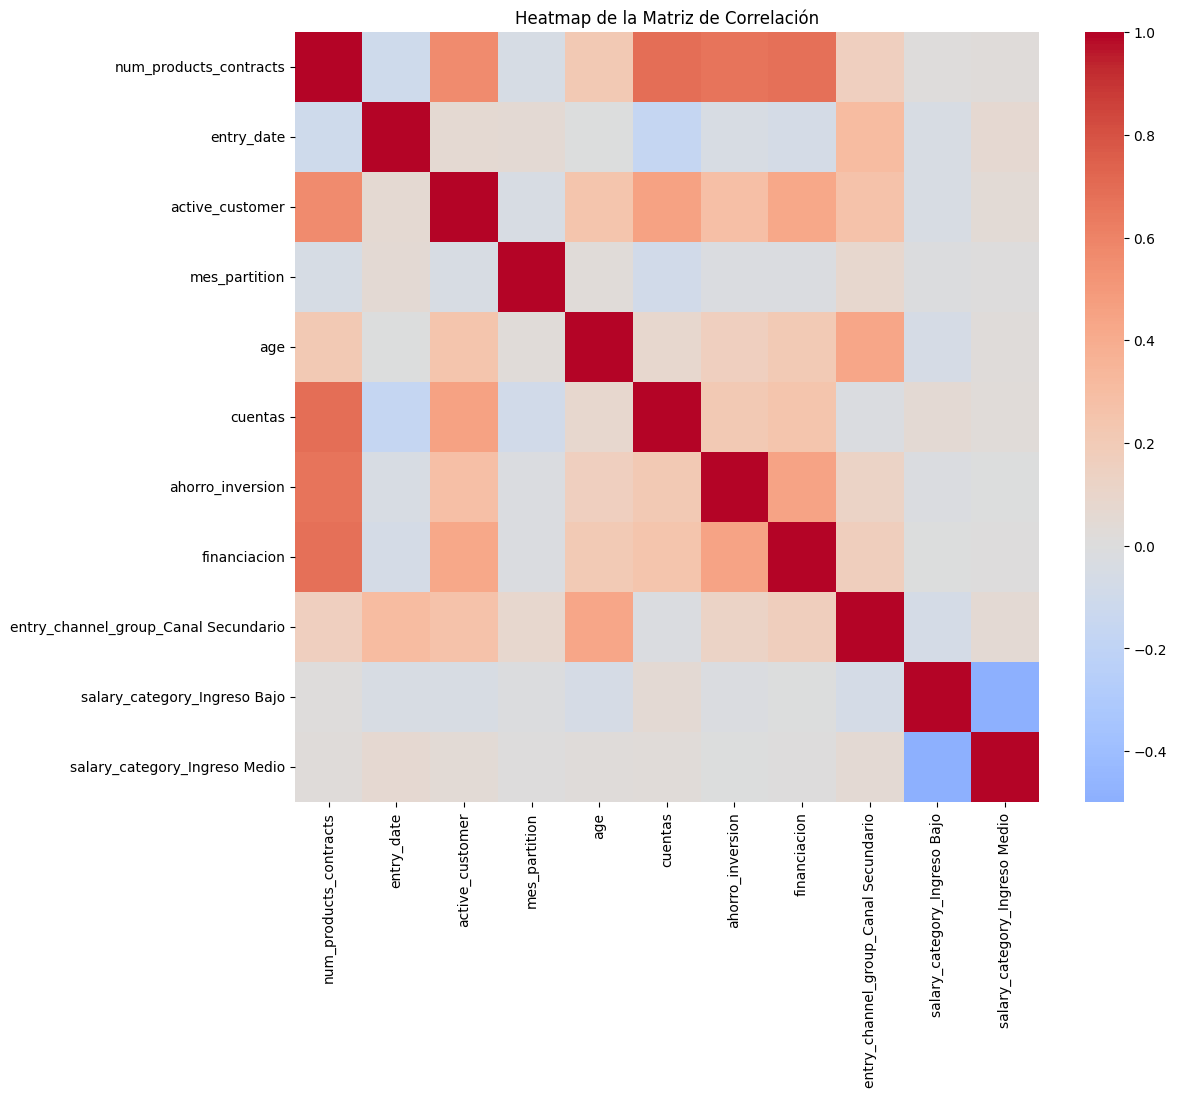

Pares de variables altamente correlacionadas:


In [34]:
# Calcular la matriz de correlación
matriz_correlacion = df_seg_3.corr()

# Visualizar la matriz de correlación utilizando un heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacion, cmap='coolwarm', center=0)
plt.title('Heatmap de la Matriz de Correlación')
plt.show()

# Identificar variables altamente correlacionadas
umbral = 0.9
correlaciones_altas = np.where(np.abs(matriz_correlacion) > umbral)
pares_correlacionados = [(matriz_correlacion.index[x], matriz_correlacion.columns[y]) for x, y in zip(*correlaciones_altas) if x != y and x < y]

print("Pares de variables altamente correlacionadas:")
for par in pares_correlacionados:
    print(par)

No existen variables altamente correlacionadas

In [35]:
df_seg_3

,num_products_contracts,entry_date,active_customer,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group_Canal Secundario,salary_category_Ingreso Bajo,salary_category_Ingreso Medio
pk_cid,,,,,,,,,,,
15891,1,736903,0.500,8,59,0.071,0.000,0.000,1,0,0
16063,0,737017,0.714,5,62,0.000,0.000,0.000,1,0,0
16203,1,737051,0.833,5,70,0.119,0.000,0.000,1,0,0
16502,2,736967,0.889,5,58,0.206,0.000,0.000,1,0,0
17457,3,736588,1.000,5,54,0.277,0.000,0.074,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1553685,0,737210,0.000,5,52,0.000,0.000,0.000,1,0,0
1553686,0,737210,0.000,5,30,0.000,0.000,0.000,1,0,1
1553687,0,737210,0.000,5,21,0.000,0.000,0.000,1,0,0


8. Estandarizacion de las variables

In [36]:
# Separar pk_cid
pk_cid = df_seg_3.index  # O también puedes usar df_seg_3['pk_cid'] si pk_cid no es el índice

# Inicializar el scaler
scaler = RobustScaler()

# Fit y transformar los datos numéricos (sin pk_cid)
df_numerico_estandarizado_3 = scaler.fit_transform(df_seg_3)

# Convertir el resultado de nuevo en un DataFrame
df_numerico_estandarizado_3 = pd.DataFrame(df_numerico_estandarizado_3, columns=df_seg_3.columns)

# Añadir nuevamente el pk_cid como una columna (o volver a ponerlo como índice)
df_numerico_estandarizado_3['pk_cid'] = pk_cid

# Verificar los resultados
df_numerico_estandarizado_3 = df_numerico_estandarizado_3.set_index('pk_cid')  # Si pk_cid era el índice original

In [37]:
df_numerico_estandarizado_3

,num_products_contracts,entry_date,active_customer,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group_Canal Secundario,salary_category_Ingreso Bajo,salary_category_Ingreso Medio
pk_cid,,,,,,,,,,,
15891,0.000,0.486,0.500,3.000,2.429,-0.773,0.000,0.000,1.000,0.000,0.000
16063,-1.000,0.641,0.714,0.000,2.643,-1.545,0.000,0.000,1.000,0.000,0.000
16203,0.000,0.688,0.833,0.000,3.214,-0.258,0.000,0.000,1.000,0.000,0.000
16502,1.000,0.573,0.889,0.000,2.357,0.687,0.000,0.000,1.000,0.000,0.000
17457,2.000,0.058,1.000,0.000,2.071,1.455,0.000,0.074,1.000,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...
1553685,-1.000,0.904,0.000,0.000,1.929,-1.545,0.000,0.000,1.000,0.000,0.000
1553686,-1.000,0.904,0.000,0.000,0.357,-1.545,0.000,0.000,1.000,0.000,1.000
1553687,-1.000,0.904,0.000,0.000,-0.286,-1.545,0.000,0.000,1.000,0.000,0.000


### 4. Analisis Clustering

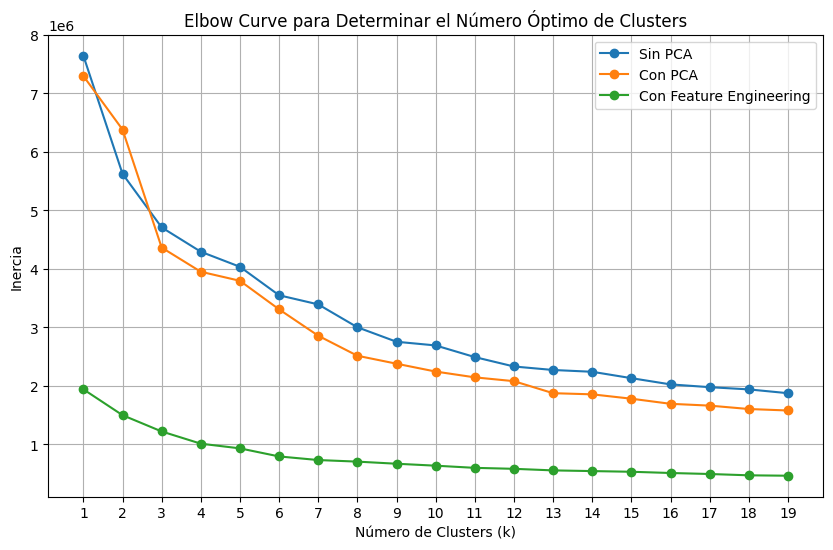

In [38]:
# Definir un rango de k (número de clusters) para probar
rango_k = range(1, 20)
inercias_original = []
inercias_pca = []
inercias = []

# Aplicar K-means para cada valor de k y calcular la inercia para el dataset original
for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_estandarizado)
    inercias_original.append(kmeans.inertia_)

# Aplicar K-means para cada valor de k y calcular la inercia para el dataset con PCA
for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    inercias_pca.append(kmeans.inertia_)

# Aplicar K-means para cada valor de k y calcular la inercia para el dataset con el Feature Engineering
for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_numerico_estandarizado_3)
    inercias.append(kmeans.inertia_)

# Graficar ambas curvas de codo en el mismo gráfico
plt.figure(figsize=(10, 6))
plt.plot(rango_k, inercias_original, marker='o', linestyle='-', label='Sin PCA')
plt.plot(rango_k, inercias_pca, marker='o', linestyle='-', label='Con PCA')
plt.plot(rango_k, inercias, marker='o', linestyle='-', label='Con Feature Engineering')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Elbow Curve para Determinar el Número Óptimo de Clusters')
plt.xticks(rango_k)
plt.grid(True)
plt.legend()
plt.show()

Como no se observa bien la curva del codo para Feature Engineering, abajo se vuelve a mostrar

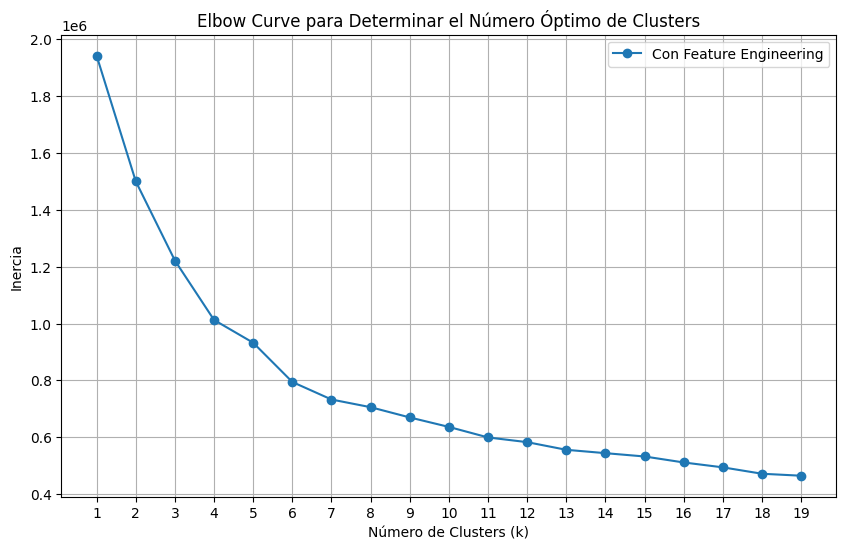

In [39]:
# Definir un rango de k (número de clusters) para probar
rango_k = range(1, 20)
inercias = []
    
for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_numerico_estandarizado_3)
    inercias.append(kmeans.inertia_)

# Graficar ambas curvas de codo en el mismo gráfico
plt.figure(figsize=(10, 6))
plt.plot(rango_k, inercias, marker='o', linestyle='-', label='Con Feature Engineering')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Elbow Curve para Determinar el Número Óptimo de Clusters')
plt.xticks(rango_k)
plt.grid(True)
plt.legend()
plt.show()

En el gráfico, el codo parece situarse entre 4, 5 o 6 clusters. Esto sugiere que agregar más clusters no proporciona una mejora significativa en la reducción de inercia, lo que implica que los clusters adicionales no están capturando mucha información adicional.

Resumiendo:


•	Feature Engineering: Este enfoque muestra la inercia más baja, lo que indica que las nuevas variables son más efectivas para capturar las diferencias entre los datos. La reducción de inercia es significativa incluso con un pequeño número de clusters, lo cual es una señal positiva de un buen diseño de las características.

•	PCA: Aunque mejora la segmentación respecto a no usar ninguna reducción de dimensionalidad, no es tan efectiva como la ingeniería de características para reducir la inercia. Sin embargo, aún presenta una mejora significativa en comparación con el dataset original.

•	Sin PCA: Este es el enfoque más básico y muestra la mayor inercia a medida que se agregan clusters, indicando que las variables originales sin transformación no son tan efectivas para segmentar los datos de manera óptima.

## 2.3. Interpretación del Clustering

### 1. Selección del cluster adecuado

In [46]:
df_numerico_estandarizado_3

,num_products_contracts,entry_date,active_customer,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group_Canal Secundario,salary_category_Ingreso Bajo,salary_category_Ingreso Medio,cluster_4,cluster_5
pk_cid,,,,,,,,,,,,,
15891,0.000,0.486,0.500,3.000,2.429,-0.773,0.000,0.000,1.000,0.000,0.000,3,3
16063,-1.000,0.641,0.714,0.000,2.643,-1.545,0.000,0.000,1.000,0.000,0.000,0,1
16203,0.000,0.688,0.833,0.000,3.214,-0.258,0.000,0.000,1.000,0.000,0.000,1,4
16502,1.000,0.573,0.889,0.000,2.357,0.687,0.000,0.000,1.000,0.000,0.000,1,4
17457,2.000,0.058,1.000,0.000,2.071,1.455,0.000,0.074,1.000,0.000,1.000,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,-1.000,0.904,0.000,0.000,1.929,-1.545,0.000,0.000,1.000,0.000,0.000,0,1
1553686,-1.000,0.904,0.000,0.000,0.357,-1.545,0.000,0.000,1.000,0.000,1.000,0,1
1553687,-1.000,0.904,0.000,0.000,-0.286,-1.545,0.000,0.000,1.000,0.000,0.000,0,1


In [54]:
# Aplicar K-Means con 4, 5 y 6 clusters para ver la distribución de los datos
kmeans_final_4 = KMeans(n_clusters=4, random_state=42)
kmeans_final_5 = KMeans(n_clusters=5, random_state=42)
kmeans_final_6 = KMeans(n_clusters=6, random_state=42)
df_numerico_estandarizado_3['cluster_4'] = kmeans_final_4.fit_predict(df_numerico_estandarizado_3)
df_numerico_estandarizado_3['cluster_5'] = kmeans_final_5.fit_predict(df_numerico_estandarizado_3)
df_numerico_estandarizado_3['cluster_6'] = kmeans_final_6.fit_predict(df_numerico_estandarizado_3)
print(df_numerico_estandarizado_3['cluster_4'].value_counts())
print(df_numerico_estandarizado_3['cluster_5'].value_counts())
print(df_numerico_estandarizado_3['cluster_6'].value_counts())

cluster_4
0    152507
1    112802
3     98429
2     92635
Name: count, dtype: int64
cluster_5
0    152507
4    112775
2     92635
1     63085
3     35371
Name: count, dtype: int64
cluster_6
0    152507
2    105654
1     92635
3     63071
5     35260
4      7246
Name: count, dtype: int64


Como se puede observar en la gráfica del codo, el número óptimo de clusters se encuentra entre 4, 5 y 6. A pesar de que en el pasado la Directora General, Carol, había propuesto segmentar la base de clientes en 7 u 8 grupos de clientes similares, hemos decidido trabajar con un máximo de 6 clusters.

Esta decisión se basa en el análisis de la inercia, que muestra que añadir más de 6 clusters no proporciona una mejora significativa en la reducción de la inercia. Esto sugiere que los clusters adicionales no capturan mucha información adicional, lo cual no justifica la complejidad añadida de más clusters. Además, la distribución de clientes en los clusters cuando se utilizan 6 grupos es bastante equilibrada y manejable, lo que facilita tanto la interpretación como la implementación de estrategias.


Optar por 6 clusters nos permite un buen equilibrio entre detalle y manejabilidad, asegurando que cada grupo es lo suficientemente grande como para proporcionar insights significativos, sin ser tan grande como para perder especificidad o ser difícil de gestionar.

Con esta tabla resumen, se obtienen las medias de las características por cluster, la distribución y el peso relativo de cada cluster en términos de volumen de productos contratados y la cantidad de clientes.

In [41]:
# Lista de columnas excluyendo las de los clusters específicos
cols = list(df_numerico_estandarizado_3.columns)
cols.remove('cluster_6') 
cols.remove("cluster_5")
cols.remove("cluster_4")

# Calcular las medias para cada cluster
pt = pd.pivot_table(df_numerico_estandarizado_3, index='cluster_6', values=cols, aggfunc='mean')

# Calcular la cantidad de elementos en cada cluster
add = pd.pivot_table(df_numerico_estandarizado_3, index='cluster_6', values='num_products_contracts', aggfunc='count')
pt['count'] = add

# Añadir 'count' a la lista de columnas para la visualización final
cols.append('count')

# Mostrar la tabla con estilos y gradientes de color
pt[cols].style.background_gradient(cmap='coolwarm')




,num_products_contracts,entry_date,active_customer,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group_Canal Secundario,salary_category_Ingreso Bajo,salary_category_Ingreso Medio,count
cluster_6,,,,,,,,,,,,
0,0.070735,-0.167430,0.345916,-0.008730,-0.010722,-0.032121,0.000256,0.007314,0.109137,0.377883,0.342622,245142
1,2.890973,-0.242925,0.946622,-0.010216,0.851729,0.512707,0.148106,0.150038,0.485456,0.312097,0.329833,35239
2,-0.964675,0.004602,0.038933,-0.016383,-0.116177,-1.536654,0.000057,0.000200,0.144939,0.263861,0.260727,73065
3,-0.488103,0.290592,0.175229,5.474350,0.728727,-1.104634,0.003191,0.008549,0.703617,0.258836,0.363911,7271
4,0.573041,0.068041,0.814849,-0.029096,1.762496,0.068336,0.007680,0.053721,0.698035,0.260929,0.374110,63067
5,-0.916598,0.035719,0.048099,-0.155912,1.422246,-1.517848,0.000370,0.001892,0.619166,0.288226,0.382890,32589


In [86]:
df_desnorm = df_seg_3.copy()
df_desnorm["cluster_6"] = df_numerico_estandarizado_3["cluster_6"]
df_desnorm.groupby("cluster_6").mean()


,num_products_contracts,entry_date,active_customer,mes_partition,age,cuentas,ahorro_inversion,financiacion,entry_channel_group_Canal Secundario,salary_category_Ingreso Bajo,salary_category_Ingreso Medio
pk_cid,,,,,,,,,,,
15891,1,736903,0.500,8,59,0.071,0.000,0.000,1,0,0
16063,0,737017,0.714,5,62,0.000,0.000,0.000,1,0,0
16203,1,737051,0.833,5,70,0.119,0.000,0.000,1,0,0
16502,2,736967,0.889,5,58,0.206,0.000,0.000,1,0,0
17457,3,736588,1.000,5,54,0.277,0.000,0.074,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1553685,0,737210,0.000,5,52,0.000,0.000,0.000,1,0,0
1553686,0,737210,0.000,5,30,0.000,0.000,0.000,1,0,1
1553687,0,737210,0.000,5,21,0.000,0.000,0.000,1,0,0


### 2. Interpretación de los cluster según variables:

salary_category_Ingreso Bajo	
- Cuanto más alto sea el valor, mayor es la concentración de clientes con ingresos bajos en ese cluster.

entry_channel_group_Canal Secundario:

- Alta Utilización de Canales Secundarios (Clusters 3, 4 y 5): Optimización de canales secundarios, campañas de fidelización específicas, y capacitación del personal para ventas cruzadas.
- Moderada Utilización de Canales Secundarios (Clusters 1 ): Incentivos para el uso de canales primarios, campañas de marketing complementarias
- Baja Utilización de Canales Secundarios (Clusters 0 y 2): Estrategias de integración multicanal, incentivos para uso primario, y campañas de lealtad específicas para usuarios de canales secundarios.


cuentas,	ahorro_inversion y	financiacion:

- Alto Uso de Cuentas y Productos Financieros (Cluster 1): Estrategias de diversificación financiera, asesoría integral, y programas de recompensas.
- Bajo Uso de Cuentas y Ahorro e Inversión (Cluster 0): Productos de entrada de bajo compromiso, campañas educativas, y promoción de cuentas sin comisiones.
- Muy Bajo Uso de Cuentas, Ahorro e Inversión, y Financiación (Clusters 2 y 5): Investigación de barreras, promoción de productos básicos, e incentivos por adopción.
- Uso Moderado de Cuentas y Bajo en Ahorro e Inversión, y Financiación (Cluster 3): Fomento de apertura de cuentas, campañas de concienciación financiera, y financiamientos de bajo riesgo.
- Uso Moderado-Alto de Cuentas y Bajo en Ahorro e Inversión, y Financiación (Cluster 4): Identificación de oportunidades de adopción de productos financieros, incentivos para contratación adicional, y promoción de financiamientos específicos.


active_customer:

- Alta Actividad de Clientes (Clusters 1 y 4): Estrategias de lealtad, venta de servicios adicionales, y comunicación personalizada.
- Moderada y Baja Actividad de Clientes (Cluster 0 y 3): Campañas de incentivo y reactivación, promoción de beneficios de uso activo, y encuestas para entender necesidades.
- Muy Baja Actividad de Clientes (Cluster 2 y 5): Investigación de causas de inactividad, promociones de uso limitado, y campañas de información.


num_products_contracts:
- Alto Número de Productos Contratados (Cluster 1): Estrategias de fidelización, venta cruzada, y productos premium.
- Moderado Número de Productos Contratados (Cluster 4): Educación sobre productos adicionales, incentivos para contratación adicional, y comunicación activa.
- Bajo Número de Productos Contratados (Clusters 0 y 3): Promoción de productos básicos, campañas de marketing dirigidas, y pruebas gratuitas.
- Muy Bajo Número de Productos Contratados (Clusters 2 y 5): Campañas de reactivación, investigación de barreras, y ofertas personalizadas.

age:
- Clusters con Edad Positiva Alta (Clusters 4 y 5): Estos clusters podrían beneficiarse de productos y servicios que se alineen con las necesidades de clientes mayores, como opciones de inversión para la jubilación, seguros de vida o productos de ahorro de bajo riesgo.
- Clusters con Edad Negativa Alta(Clusters 2): Este podría ser segmentos de mercado a los que se les pueda dirigir ofertas que atraigan a una población más joven, como tarjetas de crédito estudiantiles, préstamos para automóviles o productos financieros diseñados para el inicio de la vida laboral.
- Clusters con Edad Posistiva Moderada (Cluster 1 y 3): Productos para mediana edad, con una mezcla de inversión a mediano plazo y seguros de salud.
- Clusters con Edad Cercana a Cero (Cluster 0): Productos de uso general que no se enfocan en un grupo de edad específico.

### 3. Análisis de la Importancia de las Características para la Segmentación y así poder diferenciar entre clusters

- Se identifican las características más importantes para diferenciar entre clusters, utilizando un modelo de Random Forest básico.

In [42]:
df_numerico_estandarizado_3.columns

Index(['num_products_contracts', 'entry_date', 'active_customer',
       'mes_partition', 'age', 'cuentas', 'ahorro_inversion', 'financiacion',
       'entry_channel_group_Canal Secundario', 'salary_category_Ingreso Bajo',
       'salary_category_Ingreso Medio', 'cluster_4', 'cluster_5', 'cluster_6'],
      dtype='object')

<Axes: title={'center': 'Importancia de las Características para la Segmentación'}>

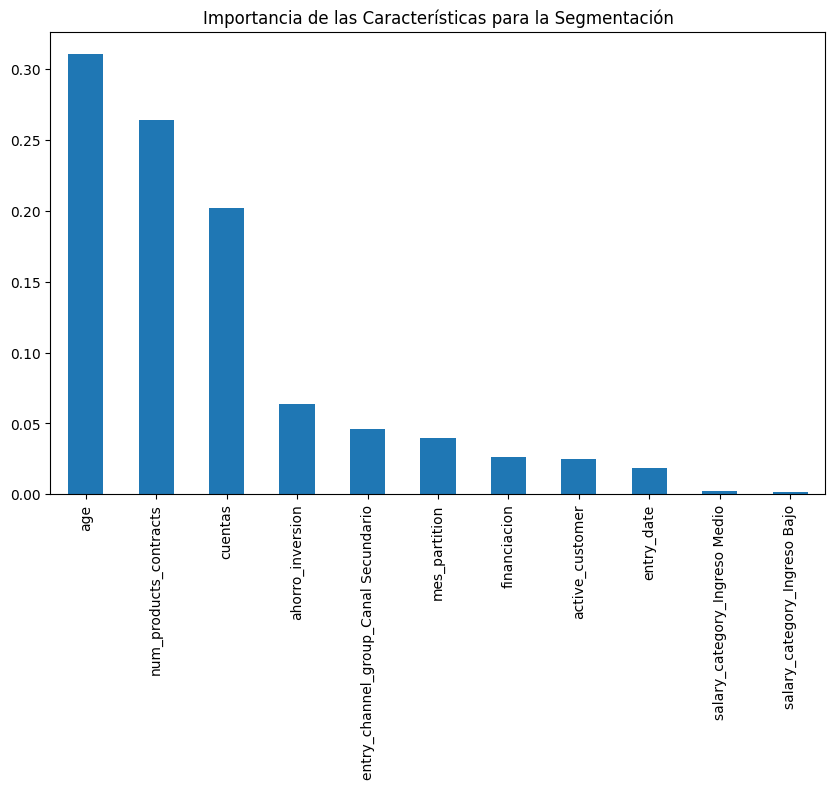

In [43]:
from sklearn.ensemble import RandomForestClassifier

df_numerico_estandarizado_3.drop(columns=["cluster_4","cluster_5"], inplace=True)
cols = ['num_products_contracts', 'entry_date', 'active_customer',"age",
       'mes_partition', 'cuentas', 'ahorro_inversion', 'financiacion',
       'entry_channel_group_Canal Secundario', 'salary_category_Ingreso Bajo',
       'salary_category_Ingreso Medio']
# Asumiendo que 'cluster_6' es la variable objetivo
X = df_numerico_estandarizado_3[cols]  # Características sin la columna de cluster
y = df_numerico_estandarizado_3['cluster_6']  # Variable objetivo

# Entrenar un modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Obtener la importancia de las características
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6), title='Importancia de las Características para la Segmentación')

- La característica más importante para la segmentación es la Edad, con un peso ligeramente superior al 20%. Esto indica que la edad es un factor clave para diferenciar a los clientes en la base de datos.

- El Número de Productos Contratados, también tiene un impacto significativo. Los clientes se agrupan en función de cuántos productos han contratado, reflejando directamente el nivel de compromiso del cliente con la entidad.

- El número de cuentas activas, también juega un papel relevante en cómo se agrupan los clientes.


### 4. Definición de los clusters

Teniendo en cuenta el análisis anterior y que el objetivo de la segmentación es conocer mejor la base de clientes para orientar la actividad comercial de la empresa, según nos propone la Directora General Carol, quedan definidos los clusters de la siguiente forma: 

---

Cluster 0: 	“Clientes Exploradores Iniciales” (Resalta su estado de iniciación en la relación con la empresa y su potencial para explorar más productos.)

  Características:

- Número de productos contratados: Bajo, sugiriendo una baja participación en servicios adicionales.
- Bajo uso de cuentas, ahorro e inversión.
- Actividad del cliente: Moderada, el tercer cluster con actividad más alta, indicando una interacción continua, pero posiblemente limitada a servicios básicos.
- Ingreso: Mayoría en categoría de ingreso bajo-medio.
- Canal de entrada: Muy bajo uso de canales secundarios, el más bajo de todos los cluster, significan que usan el canal principal.
- Dado que su edad está cerca de la media, sugiere una mezcla de edades sin una inclinación fuerte hacia jóvenes o mayores. (Edad mixta)


Descripción: 
	
- Este cluster se caracteriza por tener clientes que, aunque muestran un nivel de actividad moderado en sus interacciones con la empresa, tienen un número muy bajo de productos contratados y un uso limitado de servicios financieros adicionales como cuentas, ahorro e inversión. La mayoría de estos clientes pertenecen a categorías de ingreso bajo y medio, lo que podría limitar su capacidad o interés en adoptar más productos. Además, estos clientes no utilizan con frecuencia los canales secundarios, prefiriendo los primarios para sus interacciones con la empresa. En términos de edad, este grupo representa una mezcla diversa, sin una inclinación clara hacia clientes jóvenes o mayores.

Estrategias:

1.	Lanzamiento de Cuentas y Productos Básicos sin Comisiones:
- Ofrecer cuentas corrientes sin comisiones de mantenimiento y tarjetas de crédito con límites bajos y sin costos adicionales. Esta estrategia busca atraer a estos clientes hacia la contratación de más productos básicos y mejorar su experiencia con la empresa.
2.	Programa de Recompensas por Uso Activo:
- Implementar un programa de recompensas que ofrezca puntos o descuentos a los clientes cada vez que realicen transacciones, utilicen sus tarjetas de crédito, o contraten nuevos productos. Esto incentiva un mayor uso de los servicios y aumenta el compromiso con la empresa.
3.	Asesoría Financiera Gratuita para Incrementar Conocimiento:
- Ofrecer sesiones de asesoría financiera gratuitas o talleres en línea para educar a los clientes sobre cómo los productos de ahorro e inversión pueden beneficiarles a largo plazo. Esto ayudará a eliminar barreras de desconocimiento y a fomentar una relación más profunda con la empresa.

---

Cluster 1: “Clientes de Alto Valor” (subraya el valor significativo que representa estos clientes para la empresa debido a su lealtad y compromiso.)

Características:
- Número de productos contratados: Alto, lo que indica una alta utilización de los servicios de la empresa.
- Actividad del cliente: Muy alta, demostrando lealtad y compromiso.
- Ingreso: Ingreso medio alto.
- Canal de entrada: Media alta utilización de canales secundarios (0.48).
- Alto uso de Cuentas y Productos Financieros.
- Clientes de mediana edad.

Descripción: 

- Este cluster está compuesto por clientes que muestran un alto nivel de compromiso y lealtad hacia la empresa, utilizando múltiples productos y servicios. Con un número elevado de productos contratados y una actividad muy alta, estos clientes demuestran ser usuarios frecuentes y satisfechos de las ofertas de la empresa. La mayoría tiene un ingreso medio alto, lo que les permite aprovechar una variedad de productos financieros. Utilizan de manera significativa tanto los canales primarios como los secundarios para interactuar con la empresa, lo que sugiere que valoran la flexibilidad y la accesibilidad. Estos clientes son predominantemente de mediana edad, lo que los posiciona en una fase de vida con necesidades financieras diversas y crecientes.


Estrategias:

1. Programas de Lealtad y Recompensas Personalizados: Implementar un programa de lealtad que ofrezca recompensas exclusivas para estos clientes comprometidos.
2.	Ofrecimiento de Servicios Financieros Avanzados: Introducir productos financieros avanzados y personalizados, como asesoría financiera integral, servicios de gestión de patrimonio, o acceso a inversiones de alto rendimiento.

---

Cluster 2: 	“Clientes Pasivos o en Pausa ” (Resalta su estado de iniciación en la relación con la empresa y su potencial para explorar más productos.)

  Características:

- Número de productos contratados: Muy bajo
- Muy Bajo Uso de Cuentas, Ahorro e Inversión, y Financiación 
- Muy Baja Actividad de Clientes.
- Ingreso: salario medio bajo
- Canal de entrada: Muy bajo uso de canales secundarios.
- Clientes Jóvenes


Descripción: 
	
- Este cluster se caracteriza por estar compuesto por clientes jóvenes que han iniciado una relación con la empresa, pero cuya actividad es actualmente muy baja. Estos clientes tienen un número muy bajo de productos contratados y un uso mínimo de servicios financieros adicionales, como cuentas, ahorro, inversión y financiación. La mayoría se encuentra en la categoría de ingresos medio bajos, lo cual podría influir en su capacidad o interés por explorar y adoptar más productos financieros. Además, estos clientes prefieren no utilizar los canales secundarios, lo que sugiere que sus interacciones con la empresa son limitadas y se centran en los canales principales. Este estado de “pausa” indica que, aunque la relación con la empresa ha comenzado, todavía no ha evolucionado a un compromiso más profundo o diversificado.


Estrategias:
1.  Ofrecer incentivos atractivos para que estos clientes contraten y utilicen productos básicos, como cuentas corrientes sin comisiones, tarjetas de débito con beneficios, o programas de recompensas por la realización de su primera transacción. La idea es motivarlos a iniciar su actividad financiera con productos que requieren un bajo compromiso.


---

Cluster 3: Clientes Emergentes” (Indica que están empezando a emerger como clientes más activos.)

Características:
- Número de productos contratados: Bajo, pero en fase de crecimiento.
- Actividad del cliente: Media Baja (0.18), sugiere que están comenzando a interactuar.
- Edad: Predominantemente para personas de mediana edad.
- Canal de entrada: Alta entrada a través de canales secundarios (0.70), lo que sugiere campañas efectivas de captación inicial.
- Uso Moderado de Cuentas y Bajo en Ahorro e Inversión, y Financiación

Descripción:

Este cluster está compuesto principalmente por personas de mediana edad que están en una fase de transición en su relación con la empresa. Aunque actualmente tienen un bajo número de productos contratados y muestran una actividad media baja, hay indicios de que están comenzando a interactuar más. La alta entrada a través de canales secundarios sugiere que las campañas de captación inicial han sido efectivas, pero estos clientes aún no han explorado o adoptado plenamente productos adicionales de ahorro, inversión o financiación. Están en una fase en la que necesitan ser motivados y guiados para aprovechar más los servicios financieros de la empresa.

Estrategias:

1.	Programas de Ventas Cruzadas y Promociones Exclusivas: Implementar campañas de ventas cruzadas que ofrezcan promociones exclusivas a estos clientes para incentivar la contratación de productos adicionales.

2.	Iniciativas de Educación Financiera y Workshops: Organizar talleres y seminarios específicos para estos clientes, centrados en la importancia del ahorro y la inversión, y cómo pueden optimizar su situación financiera utilizando los productos de la empresa. 

---

Cluster 4: “Clientes Senior en Expansión” (Se destaca su edad mayor y el potencial para expandir su relación con la empresa.)

Características:

- Número de productos contratados: Moderado, con potencial de incremento.
- Actividad del cliente: Alta, señal de un compromiso sólido.
- Ingreso: presencia significativa en las categorías de ingresos medio altos.
- Canal de entrada: Preferencia marcada por canales secundarios.

- Uso Moderado-Alto de Cuentas y Bajo en Ahorro e Inversión, y Financiación 

- Clientes mayores.

Descripción: 

- Este cluster está compuesto por clientes mayores que ya muestran un alto nivel de compromiso con la empresa, utilizando un número moderado de productos y mostrando una actividad alta. Estos clientes tienden a tener ingresos medios altos, lo que sugiere una estabilidad financiera que podría facilitar la adopción de más productos en el futuro. Prefieren interactuar a través de canales secundarios, lo que indica que valoran la flexibilidad y opciones variadas de comunicación. Actualmente, su uso de cuentas es moderado a alto, pero su participación en productos de ahorro, inversión y financiación es baja, lo que presenta una oportunidad para la empresa de expandir su relación con estos clientes.

Estrategias:

- Crear y promover productos de ahorro e inversión específicamente diseñados para clientes mayores, como cuentas de ahorro con tasas de interés preferenciales o productos de inversión de bajo riesgo. 
	

---










Cluster 5: “Clientes Senior Tradicionalistas” (Sugiere su inclinación por mantener métodos tradicionales y básicos en su relación financiera.)

Características:
- Número de productos contratados: Muy bajo, indicando un enfoque limitado en diversificación de productos.
- Actividad del cliente: Muy Baja, pero presente en servicios básicos.
- Ingreso: Mayormente en categorías de ingreso medio alto
- Canal de entrada: Alta Utilización de Canales Secundarios.
- Muy Bajo Uso de Cuentas, Ahorro e Inversión, y Financiación 
- Clientes mayores.

Descripción: 

- Este cluster está compuesto por clientes mayores que tienen un enfoque muy limitado en la diversificación de productos financieros, reflejado en un número muy bajo de productos contratados. Aunque muestran alguna actividad, esta se centra principalmente en servicios básicos, con una participación mínima en cuentas, ahorro, inversión y financiación. La mayoría de estos clientes se encuentran en la categoría de ingreso medio alto, lo que sugiere que podrían tener la capacidad de contratar más productos, pero actualmente no lo hacen. Utilizan predominantemente canales secundarios para su interacción con la empresa, lo que indica que valoran opciones de acceso más tradicionales o personalizadas.

Estrategias:

- Crear y promover productos financieros básicos adaptados a las necesidades de los clientes mayores, 


### 5. Tabla resumen

In [85]:
# Datos para la tabla
data_summary = {
    "Cluster": [
        "Clientes Exploradores Iniciales", 
        "Clientes de Alto Valor", 
        "Clientes Pasivos o en Pausa",
        "Clientes Emergentes", 
        "Clientes Senior en Expansión", 
        "Clientes Senior Tradicionalistas"
    ],
    "Número de Productos Contratados": [
        "Bajo", 
        "Alto", 
        "Muy Bajo", 
        "Bajo", 
        "Moderado", 
        "Muy Bajo"
    ],
    "Actividad del Cliente": [
        "Moderada", 
        "Muy Alta", 
        "Muy Baja", 
        "Media Baja", 
        "Alta", 
        "Muy Baja"
    ],
    "Ingreso": [
        "Ingreso Bajo/Medio", 
        "Ingreso Medio Alto", 
        "Ingreso Medio Bajo", 
        "Ingreso Medio", 
        "Mixto/Medio Alto", 
        "Medio Alto"
    ],
    "Canal de Entrada": [
        "Bajo uso de secundarios", 
        "Media alta en secundarios", 
        "Muy bajo uso de secundarios", 
        "Alta en secundarios", 
        "Alta en secundarios", 
        "Alta en secundarios"
    ],
    "Edad": [
        "Mixta", 
        "Mediana Edad", 
        "Jóvenes", 
        "Mediana Edad", 
        "Mayores", 
        "Mayores"
    ],
    "Uso de Cuentas, Ahorro e Inversión": [
        "Bajo", 
        "Alto", 
        "Muy Bajo", 
        "Moderado/Bajo", 
        "Moderado-Alto/Bajo", 
        "Muy Bajo"
    ],
    "Descripción Breve": [
        "Clientes con actividad moderada y potencial para explorar más productos.",
        "Clientes leales, usando múltiples productos financieros.",
        "Clientes jóvenes con baja actividad y compromiso.",
        "Clientes de mediana edad en fase de transición y crecimiento.",
        "Clientes mayores con compromiso y potencial para más productos.",
        "Clientes mayores con enfoque en métodos tradicionales y básicos."
    ],
    "Estrategias Clave": [
        "Cuentas sin comisiones, recompensas, asesoría gratuita.",
        "Programas de lealtad personalizados, servicios financieros avanzados.",
        "Incentivos para productos básicos.",
        "Ventas cruzadas, educación financiera.",
        "Productos de ahorro/inversión para mayores.",
        "Productos financieros básicos adaptados a mayores."
    ]
}

# Crear el dataframe
df_summary = pd.DataFrame(data_summary)

# Mostrar la tabla
df_summary

,Cluster,Número de Productos Contratados,Actividad del Cliente,Ingreso,Canal de Entrada,Edad,"Uso de Cuentas, Ahorro e Inversión",Descripción Breve,Estrategias Clave
0,Clientes Exploradores Iniciales,Bajo,Moderada,Ingreso Bajo/Medio,Bajo uso de secundarios,Mixta,Bajo,Clientes con actividad moderada y potencial pa...,"Cuentas sin comisiones, recompensas, asesoría ..."
1,Clientes de Alto Valor,Alto,Muy Alta,Ingreso Medio Alto,Media alta en secundarios,Mediana Edad,Alto,"Clientes leales, usando múltiples productos fi...","Programas de lealtad personalizados, servicios..."
2,Clientes Pasivos o en Pausa,Muy Bajo,Muy Baja,Ingreso Medio Bajo,Muy bajo uso de secundarios,Jóvenes,Muy Bajo,Clientes jóvenes con baja actividad y compromiso.,Incentivos para productos básicos.
3,Clientes Emergentes,Bajo,Media Baja,Ingreso Medio,Alta en secundarios,Mediana Edad,Moderado/Bajo,Clientes de mediana edad en fase de transición...,"Ventas cruzadas, educación financiera."
4,Clientes Senior en Expansión,Moderado,Alta,Mixto/Medio Alto,Alta en secundarios,Mayores,Moderado-Alto/Bajo,Clientes mayores con compromiso y potencial pa...,Productos de ahorro/inversión para mayores.
5,Clientes Senior Tradicionalistas,Muy Bajo,Muy Baja,Medio Alto,Alta en secundarios,Mayores,Muy Bajo,Clientes mayores con enfoque en métodos tradic...,Productos financieros básicos adaptados a mayo...
